In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1)

# print(mnist.keys())

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

from sklearn.base import BaseEstimator

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

from sklearn.metrics import roc_curve, roc_auc_score

In [24]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

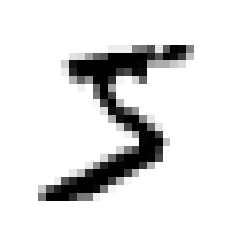

In [4]:
X, y = pd.DataFrame(mnist["data"]).to_numpy(), mnist['target']

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = "binary")
plt.axis("off")
plt.show()

In [5]:
y=y.astype(np.uint8)

X_train, X_test, y_train, y_test = X[:6000], X[6000:], y[:6000], y[6000:]

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([X[0]])
# Will print true

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring = "accuracy")
# array([0.962 , 0.956 , 0.9665])

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring = "accuracy")

array([0.91 , 0.915, 0.918])

In [6]:
# Implementing Cross-Validation

skfolds = StratifiedKFold(n_splits = 3, shuffle=True, random_state = 42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9615
0.962
0.963


In [7]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)
confusion_matrix(y_train_5, y_train_pred)

array([[5375,  111],
       [ 120,  394]], dtype=int64)

In [8]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[5486,    0],
       [   0,  514]], dtype=int64)

In [9]:
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))
print(f1_score(y_train_5, y_train_pred))

0.7801980198019802
0.7665369649805448
0.7733071638861628


In [10]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[38042.34312442]
[ True]


In [11]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[ True]


In [12]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

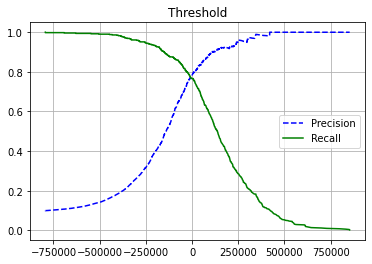

In [13]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.title("Threshold")
plt.legend()
plt.grid()
plt.show()

In [14]:
threshold_90_precision = thresholds[np.argmax(precisions>= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

precision_score(y_train_5, y_train_pred_90)
# 0.9012345679012346

recall_score(y_train_5, y_train_pred_90)

0.5680933852140078

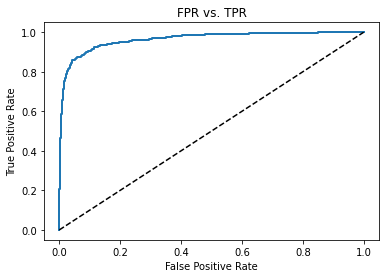

0.9641599203348885


In [15]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("FPR vs. TPR")
    
plot_roc_curve(fpr, tpr)
plt.show()
print(roc_auc_score(y_train_5, y_scores))

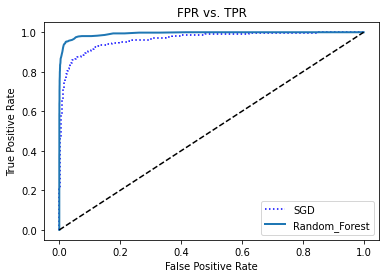

0.9936162229715256


In [16]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = "predict_proba")

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random_Forest")
plt.legend(loc = "lower right")
plt.show()
print(roc_auc_score(y_train_5, y_scores_forest))

# print(precision_score(y_train_5, y_scores_forest))
# print(recall_score(y_train_5, y_scores_forest))

In [17]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)

num = X[3]
print(svm_clf.decision_function([num]))
print(np.argmax(svm_clf.decision_function([num])))

[[-0.29775336  9.30929007  8.2791636   4.88579549  3.78683281  1.7330001
   0.72639745  6.11547363  7.27630075  2.73173708]]
1


In [18]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
print(len(ovr_clf.estimators_))
ovr_clf.predict([some_digit])

10


array([5], dtype=uint8)

In [19]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])
print(sgd_clf.decision_function([some_digit]))
print(cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy"))

[[-735711.69660953 -857058.38635209 -281086.00104909    8289.73273042
  -616793.26669143   29040.2961313  -492305.02284074 -834395.17091855
  -318385.3774766  -363474.38706356]]
[0.8565 0.8715 0.8635]


In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = "accuracy")

array([0.8705, 0.8985, 0.8925])

[[572   0   1   2   1   9   3   1   3   0]
 [  0 637   6   3   1   5   0   1  16   2]
 [ 10  12 493  11  10   4  10   9  20   2]
 [  3   5  21 514   1  35   1   7  11  10]
 [  3   2   7   0 556   2  10   8   9  26]
 [  5   6   5  24  14 411  10   1  25  13]
 [  4   4   6   0   5   6 577   1   5   0]
 [  3   4   7   2   9   0   1 577   3  45]
 [  2  19  13  16   4  10   6   3 464  14]
 [  7   4   5   7  15   3   0  27  11 522]]


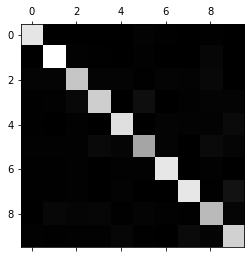

In [21]:
### Error Analysis

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

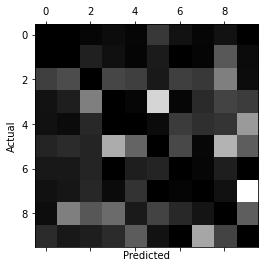

In [22]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

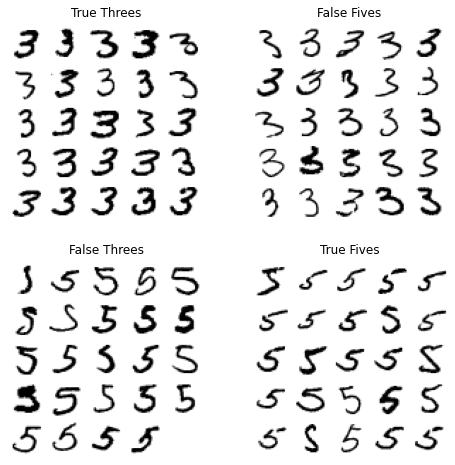

In [34]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

plt.subplot(221).set_title("True Threes")
plt.subplot(222).set_title("False Fives")
plt.subplot(223).set_title("False Threes")
plt.subplot(224).set_title("True Fives")

plt.show()

In [38]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

print(knn_clf.predict([some_digit]))

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average = "weighted") # or macro

[[False  True]]


0.9529944300252725

[5]


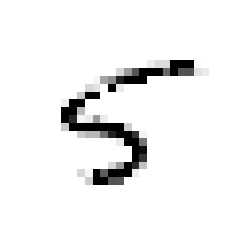

In [48]:
noise = np.random.randint(0,100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100,(len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

some_index = 4
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
print(ovr_clf.predict(clean_digit))
plot_digits(clean_digit)
